<IPython.core.display.Javascript object>


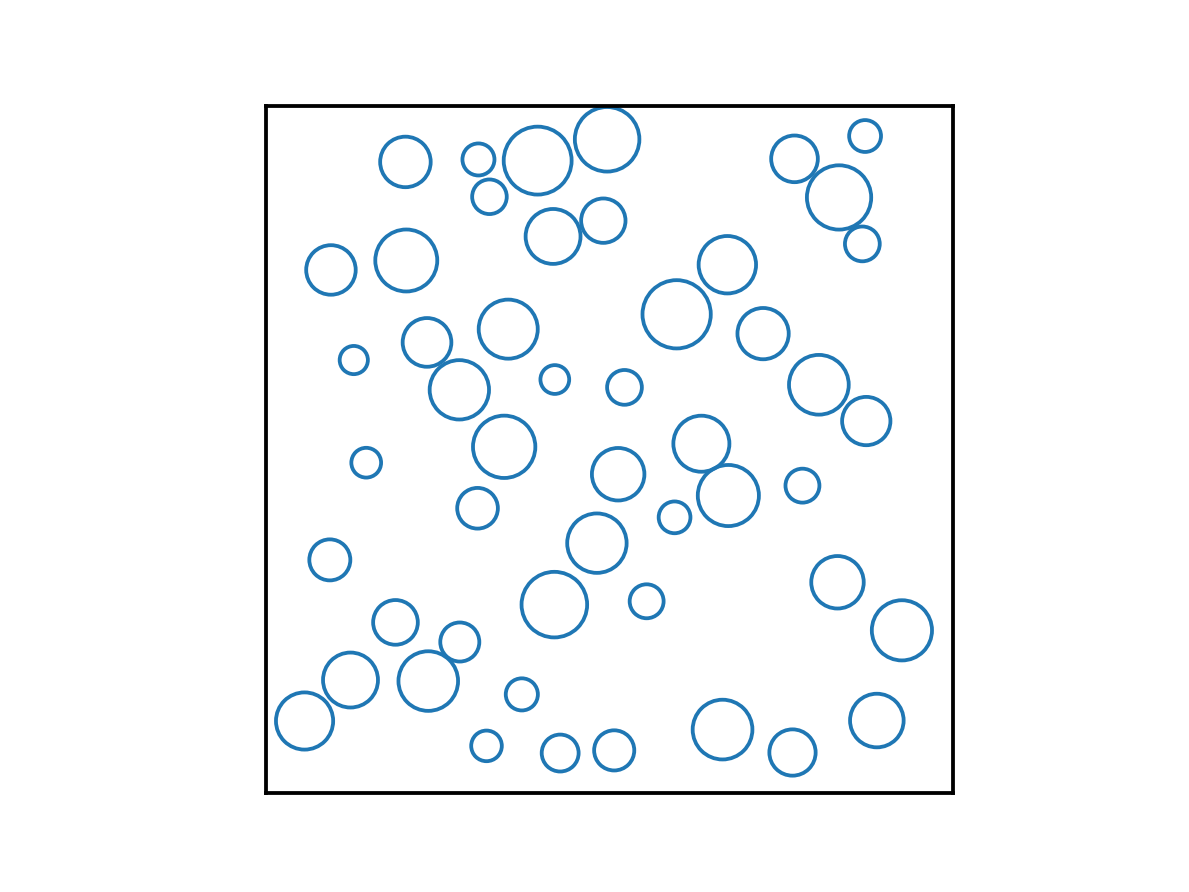

Animation size has reached 20984314 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from itertools import combinations


class Particle:
    """A class representing a two-dimensional particle."""

    def __init__(self, x, y, vx, vy, radius=0.01, styles=None):
        """Initialize the particle's position, velocity, and radius.

        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor.

        """

        self.r = np.array((x, y))
        self.v = np.array((vx, vy))
        self.radius = radius

        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'b', 'fill': False}

    # For convenience, map the components of the particle's position and
    # velocity vector onto the attributes x, y, vx and vy.
    @property
    def x(self):
        return self.r[0]
    @x.setter
    def x(self, value):
        self.r[0] = value
    @property
    def y(self):
        return self.r[1]
    @y.setter
    def y(self, value):
        self.r[1] = value
    @property
    def vx(self):
        return self.v[0]
    @vx.setter
    def vx(self, value):
        self.v[0] = value
    @property
    def vy(self):
        return self.v[1]
    @vy.setter
    def vy(self, value):
        self.v[1] = value

    def overlaps(self, other):
        """Does the circle of this Particle overlap that of other?"""

        return np.hypot(*(self.r - other.r)) < self.radius + other.radius

    def draw(self, ax):
        """Add this Particle's Circle patch to the Matplotlib Axes ax."""

        circle = Circle(xy=self.r, radius=self.radius, **self.styles)
        ax.add_patch(circle)
        return circle

    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""

        self.r += self.v * dt

        # Make the Particles bounce off the walls
        if self.x - self.radius < 0:
            self.x = self.radius
            self.vx = -self.vx
        if self.x + self.radius > 1:
            self.x = 1-self.radius
            self.vx = -self.vx
        if self.y - self.radius < 0:
            self.y = self.radius
            self.vy = -self.vy
        if self.y + self.radius > 1:
            self.y = 1-self.radius
            self.vy = -self.vy

class Simulation:
    """A class for a simple hard-circle molecular dynamics simulation.

    The simulation is carried out on a square domain: 0 <= x < 1, 0 <= y < 1.

    """

    def __init__(self, n, radius=0.01, styles=None):
        """Initialize the simulation with n Particles with radii radius.

        radius can be a single value or a sequence with n values.

        Any key-value pairs passed in the styles dictionary will be passed
        as arguments to Matplotlib's Circle patch constructor when drawing
        the Particles.

        """

        self.init_particles(n, radius, styles)

    def init_particles(self, n, radius, styles=None):
        """Initialize the n Particles of the simulation.

        Positions and velocities are chosen randomly; radius can be a single
        value or a sequence with n values.

        """

        try:
            iterator = iter(radius)
            assert n == len(radius)
        except TypeError:
            # r isn't iterable: turn it into a generator that returns the
            # same value n times.
            def r_gen(n, radius):
                for i in range(n):
                    yield radius
            radius = r_gen(n, radius)

        self.n = n
        self.particles = []
        for i, rad in enumerate(radius):
            # Try to find a random initial position for this particle.
            while True:
                # Choose x, y so that the Particle is entirely inside the
                # domain of the simulation.
                x, y = rad + (1 - 2*rad) * np.random.random(2)
                # Choose a random velocity (within some reasonable range of
                # values) for the Particle.
                vr = 0.1 * np.random.random() + 0.05
                vphi = 2*np.pi * np.random.random()
                vx, vy = vr * np.cos(vphi), vr * np.sin(vphi)
                particle = Particle(x, y, vx, vy, rad, styles)
                # Check that the Particle doesn't overlap one that's already
                # been placed.
                for p2 in self.particles:
                    if p2.overlaps(particle):
                        break
                else:
                    self.particles.append(particle)
                    break

    def handle_collisions(self):
        """Detect and handle any collisions between the Particles.

        When two Particles collide, they do so elastically: their velocities
        change such that both energy and momentum are conserved.

        """

        def change_velocities(p1, p2):
            """
            Particles p1 and p2 have collided elastically: update their
            velocities.

            """

            m1, m2 = p1.radius**2, p2.radius**2
            M = m1 + m2
            r1, r2 = p1.r, p2.r
            d = np.linalg.norm(r1 - r2)**2
            v1, v2 = p1.v, p2.v
            u1 = v1 - 2*m2 / M * np.dot(v1-v2, r1-r2) / d * (r1 - r2)
            u2 = v2 - 2*m1 / M * np.dot(v2-v1, r2-r1) / d * (r2 - r1)
            p1.v = u1
            p2.v = u2

        # We're going to need a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indexes
        # into the self.particles list of Particles on the fly.
        pairs = combinations(range(self.n), 2)
        for i,j in pairs:
            if self.particles[i].overlaps(self.particles[j]):
                change_velocities(self.particles[i], self.particles[j])

    def advance_animation(self, dt):
        """Advance the animation by dt, returning the updated Circles list."""

        for i, p in enumerate(self.particles):
            p.advance(dt)
            self.circles[i].center = p.r
        self.handle_collisions()
        return self.circles

    def advance(self, dt):
        """Advance the animation by dt."""
        for i, p in enumerate(self.particles):
            p.advance(dt)
        self.handle_collisions()

    def init(self):
        """Initialize the Matplotlib animation."""

        self.circles = []
        for particle in self.particles:
            self.circles.append(particle.draw(self.ax))
        return self.circles

    def animate(self, i):
        """The function passed to Matplotlib's FuncAnimation routine."""

        self.advance_animation(0.01)
        return self.circles

    def do_animation(self, save=False):
        """Set up and carry out the animation of the molecular dynamics.

        To save the animation as a MP4 movie, set save=True.
        """

        fig, self.ax = plt.subplots()
        for s in ['top','bottom','left','right']:
            self.ax.spines[s].set_linewidth(2)
        self.ax.set_aspect('equal', 'box')
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)
        self.ax.xaxis.set_ticks([])
        self.ax.yaxis.set_ticks([])
        anim = animation.FuncAnimation(fig, self.animate, init_func=self.init,
                               frames=800, interval=2, blit=True)
        
        from IPython.display import HTML
        HTML(anim.to_jshtml())
        
        if save:
            Writer = animation.writers['ffmpeg']
            writer = Writer(fps=100, bitrate=1800)
            anim.save('collision.mp4', writer=writer)
        else:
            plt.show()


#if __name__ == '__main__':

nparticles = 50
radii = np.random.random(nparticles)*0.03+0.02
styles = {'edgecolor': 'C0', 'linewidth': 2, 'fill': None}
sim = Simulation(nparticles, radii, styles)
sim.do_animation(save=False)





In [8]:
pip install ElasticCollision 

#from here : https://github.com/yoyoberenguer/Elastic-Collision

Note: you may need to restart the kernel to use updated packages.


In [9]:
from pygame.math import Vector2
from ElasticCollision.ec_game import momentum_trigonometry

vector1 = Vector2(0.707, 0.707)
centre1 = Vector2(0.0, 0.0)
vector2 = Vector2(-0.707, -0.707)
centre2 = Vector2(1.4142, 1.4142)
mass1 = 1.0
mass2 = 1.0
v11, v12 = momentum_trigonometry(
    centre1, centre2, vector1, vector2, mass1, mass2, True)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
from ElasticCollision import *
from ElasticCollision.tests.test_ec_game import run_testsuite
run_testsuite()

..........FF

Momentum trigonometry - object1 vector : (x:%s y:%s)  (-0.7070004940032959, -0.706999659538269)
Momentum trigonometry - object2 vector : (x:%s y:%s)  (0.7070006132125854, 0.7069995403289795)
Momentum angle free - object1 vector : (x:%s y:%s)  (-0.7070000171661377, -0.7070000171661377)
Momentum angle free - object2 vector : (x:%s y:%s)  (0.7070000171661377, 0.7070000171661377)
Momentum Trigonometry - object1 vector : (x:%s y:%s)  (-0.7070004940032959, 0.706999659538269)
Momentum Trigonometry - object2 vector : (x:%s y:%s)  (0.7070006132125854, -0.7069995403289795)
Momentum Trigonometry - object 1 vector : (x:%s y:%s)  (-0.7070004940032959, -0.706999659538269)
Momentum Trigonometry - object 2 vector : (x:%s y:%s)  (0.7070005536079407, 0.7069994807243347)
Momentum angle free - object 1 vector : (x:%s y:%s)  (-0.7070000171661377, -0.7070000171661377)
Momentum angle free - object 2 vector : (x:%s y:%s)  (0.7070000171661377, 0.7070000171661377)
Momentum angle free - object 1 vector : (x:%s y


FAIL: runTest (ElasticCollision.tests.test_ec_game.TestMomentumAngleFreeC)
RETURN VECTORS V1 & V2 AFTER OBJECT COLLISION (ANGLE FREE METHOD)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ElasticCollision\tests\test_ec_game.py", line 589, in runTest
    self.assertAlmostEqual(round(v11.y, 3), round(math.sin(math.pi / 4.0), 3))
AssertionError: -0.707 != 0.707 within 7 places (1.414 difference)

FAIL: runTest (ElasticCollision.tests.test_ec_game.TestMomentumTrigonometryC)
RETURN VECTORS V1 & V2 AFTER OBJECT COLLISION (TRIGONOMETRY)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ElasticCollision\tests\test_ec_game.py", line 658, in runTest
    self.assertAlmostEqual(round(v11.y, 3), round(math.sin(math.pi / 4.0), 3))
AssertionError: -0.707 != 0.707 within 7 places (1.414 

In [11]:
from ElasticCollision import *
from ElasticCollision.tests.test_ec_real import run_testsuite
run_testsuite()

..

Momentum trigonometry - object1 vector : (x:%s y:%s)  (-0.7070004940032959, -0.706999659538269)
Momentum trigonometry - object2 vector : (x:%s y:%s)  (0.7070006132125854, 0.7069995403289795)
Momentum angle free - object1 vector : (x:%s y:%s)  (-0.7070000171661377, -0.7070000171661377)
Momentum angle free - object2 vector : (x:%s y:%s)  (0.7070000171661377, 0.7070000171661377)



----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK
